# Contents
* Load Dataset
* EDA print samples
* Preprocesss - convert into tensors, train split 
* Create batch size and data loaders
* Move to devices
* Create model
* Create fit function
* Create acuracy evaluate function
* Train
* Print results
* Plot curves and predictions

# Imports

In [ ]:
import torch
import torchvision
from  torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import os
import tarfile
import zipfile
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vishnupraneeth","key":"9d6900a1719bc5fb66763330e6b95158"}'}

In [ ]:
!mkdir ~/.kaggle/
!cp kaggle.json  ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!rm kaggle.json

In [ ]:
!kaggle datasets download 'splcher/animefacedataset'

animefacedataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
zip_1 = 'animefacedataset.zip'
zip_ref = zipfile.ZipFile(zip_1, 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
!mkdir 'animefacedataset'
!mv './images/' './animefacedataset'

In [ ]:
# os.listdir('./images')
DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


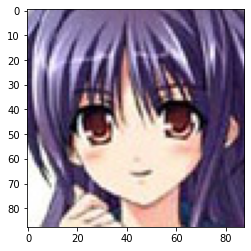

In [ ]:
plt.imshow(plt.imread(DATA_DIR+'/images/17627_2007.jpg'))

# PreProcess

In [ ]:
image_size = 64
batch_size = 128
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [ ]:
stats

((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [ ]:
train_tfms = T.Compose([T.Resize(image_size),
                         T.CenterCrop(image_size),
                        T.ToTensor(),
                        T.Normalize(*stats,inplace=True)])

In [ ]:
train_ds = ImageFolder(DATA_DIR,train_tfms)
train_ds[0][0].shape

torch.Size([3, 64, 64])

In [ ]:
train_ds[45]

(tensor([[[ 0.9843,  1.0000,  1.0000,  ...,  0.5373,  0.7020,  0.3647],
          [ 0.9922,  0.9922,  0.9765,  ...,  0.4902,  0.6784,  0.3804],
          [ 0.9529,  1.0000,  1.0000,  ...,  0.5137,  0.5922,  0.4353],
          ...,
          [ 0.9059,  0.9686,  1.0000,  ..., -0.0980, -0.0510,  0.0745],
          [ 0.9137,  0.9843,  1.0000,  ..., -0.0118, -0.0902,  0.0510],
          [ 0.9686,  0.9765,  1.0000,  ..., -0.0510, -0.1451, -0.0118]],
 
         [[ 1.0000,  1.0000,  0.9843,  ..., -0.2549, -0.0118, -0.2627],
          [ 0.9922,  0.9843,  0.9373,  ..., -0.3020, -0.0588, -0.2863],
          [ 0.9451,  0.9686,  0.9451,  ..., -0.3098, -0.1686, -0.2627],
          ...,
          [ 0.2078,  0.2235,  0.1922,  ..., -0.4118, -0.5686, -0.6157],
          [ 0.2000,  0.2392,  0.2157,  ..., -0.3020, -0.5686, -0.6000],
          [ 0.2235,  0.2000,  0.2471,  ..., -0.2941, -0.5686, -0.6000]],
 
         [[ 0.9922,  1.0000,  0.9608,  ..., -0.4745, -0.2392, -0.5216],
          [ 0.9922,  0.9686,

In [ ]:
def denormalize(img_tensor,stats):
  return img_tensor*stats[0][0] + stats[1][0]

In [ ]:
# Show images from dataset
def show_image(train_ds,index):
  img = train_ds[index][0].permute(1,2,0)
  img = denormalize(img,stats)
  plt.imshow(img)


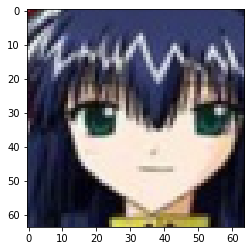

In [ ]:
show_image(train_ds,5)

In [ ]:
# Initializae dataloader with batch size
batch_size = 128
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=4,pin_memory=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def show_images(images):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    denorm_images = denormalize(images, stats)
    ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


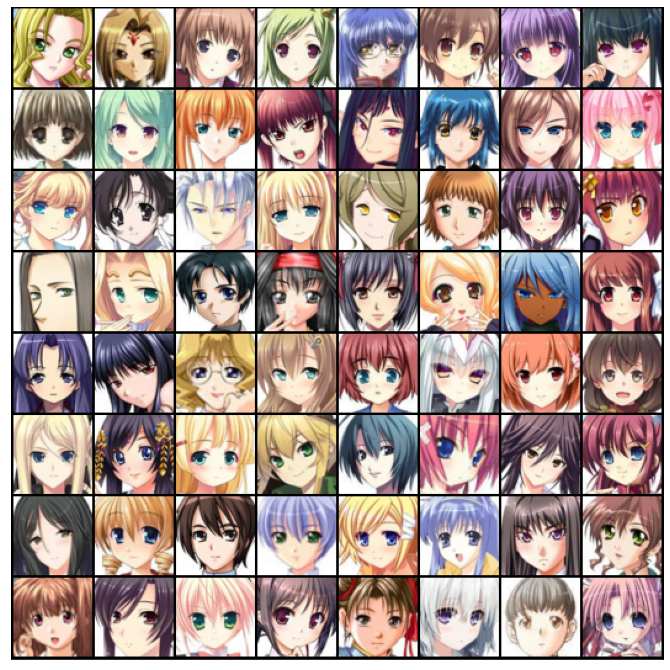

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break
show_batch(train_dl)

# GPU Move

In [ ]:
# Create the GPU setup required
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else: 
    return torch.device('cpu')

def to_device(data,device):
  if isinstance(data, (list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking = True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
# Check current device
device = get_default_device()
device

device(type='cuda')

In [ ]:
# Move dataset/ dataloaders and model to GPU
train_dl = DeviceDataLoader(train_dl, device)

# Discriminator Model

Create a model class with all the required functions like train step, val step, etc

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

discriminator = to_device(discriminator, device)

# Generator Network

In [ ]:
latent_size = 128
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)


torch.Size([128, 3, 64, 64])


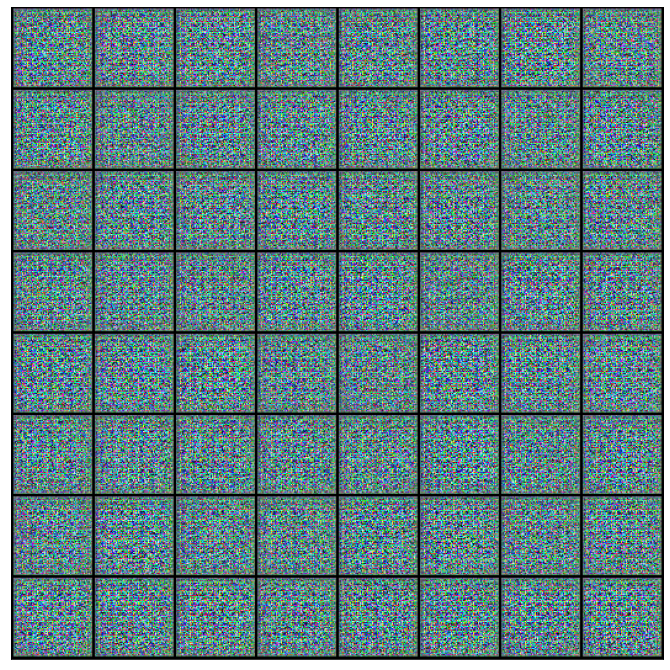

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator( opt_g):
    # Clear discriminator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass real images through discriminator
    fake_preds = discriminator(fake_images)
    fake_targets = torch.ones(fake_images.size(0), 1, device=device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    # fake_score = torch.mean(fake_preds).item()
    
    # Update discriminator weights
    loss = fake_loss
    loss.backward()
    opt_g.step()
    return loss.item()

In [ ]:
from torchvision.utils import save_image
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denormalize(fake_images,stats), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


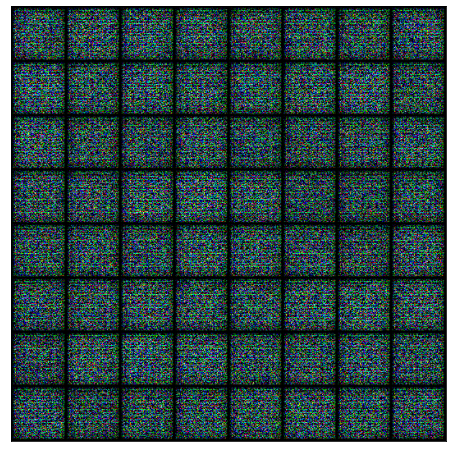

In [ ]:
generator = to_device(generator, device)
discriminator = to_device(discriminator,device)
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 25

# Training

In [ ]:
history = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/25], loss_g: 3.2178, loss_d: 0.1317, real_score: 0.9326, fake_score: 0.0449
Saving generated-images-0001.png



Epoch [2/25], loss_g: 3.3867, loss_d: 0.2450, real_score: 0.8888, fake_score: 0.1052
Saving generated-images-0002.png



Epoch [3/25], loss_g: 7.0678, loss_d: 1.7881, real_score: 0.2449, fake_score: 0.0007
Saving generated-images-0003.png



Epoch [4/25], loss_g: 4.5363, loss_d: 0.3471, real_score: 0.7770, fake_score: 0.0285
Saving generated-images-0004.png



Epoch [5/25], loss_g: 8.6010, loss_d: 0.6369, real_score: 0.9962, fake_score: 0.3974
Saving generated-images-0005.png



Epoch [6/25], loss_g: 4.2548, loss_d: 0.1079, real_score: 0.9396, fake_score: 0.0354
Saving generated-images-0006.png



Epoch [7/25], loss_g: 4.9163, loss_d: 0.0928, real_score: 0.9312, fake_score: 0.0147
Saving generated-images-0007.png



Epoch [8/25], loss_g: 3.7058, loss_d: 1.5623, real_score: 0.3241, fake_score: 0.0001
Saving generated-images-0008.png



Epoch [9/25], loss_g: 5.8281, loss_d: 0.2537, real_score: 0.9581, fake_score: 0.1669
Saving generated-images-0009.png



Epoch [10/25], loss_g: 5.0519, loss_d: 0.1519, real_score: 0.9265, fake_score: 0.0581
Saving generated-images-0010.png



Epoch [11/25], loss_g: 7.1460, loss_d: 0.2613, real_score: 0.8387, fake_score: 0.0003
Saving generated-images-0011.png



Epoch [12/25], loss_g: 6.3408, loss_d: 0.1420, real_score: 0.9867, fake_score: 0.1019
Saving generated-images-0012.png



Epoch [13/25], loss_g: 11.3927, loss_d: 0.7836, real_score: 1.0000, fake_score: 0.3947
Saving generated-images-0013.png



Epoch [14/25], loss_g: 4.0920, loss_d: 0.1819, real_score: 0.8930, fake_score: 0.0484
Saving generated-images-0014.png



Epoch [15/25], loss_g: 3.4149, loss_d: 0.2675, real_score: 0.8561, fake_score: 0.0313
Saving generated-images-0015.png



Epoch [16/25], loss_g: 4.6562, loss_d: 0.1681, real_score: 0.9044, fake_score: 0.0427
Saving generated-images-0016.png



Epoch [17/25], loss_g: 5.4391, loss_d: 0.3456, real_score: 0.9831, fake_score: 0.2301
Saving generated-images-0017.png



Epoch [18/25], loss_g: 4.3449, loss_d: 0.1249, real_score: 0.9400, fake_score: 0.0503
Saving generated-images-0018.png



Epoch [19/25], loss_g: 3.9554, loss_d: 0.1539, real_score: 0.9228, fake_score: 0.0454
Saving generated-images-0019.png



Epoch [20/25], loss_g: 4.5395, loss_d: 0.1565, real_score: 0.8885, fake_score: 0.0189
Saving generated-images-0020.png



Epoch [21/25], loss_g: 4.0326, loss_d: 0.0627, real_score: 0.9655, fake_score: 0.0249
Saving generated-images-0021.png



Epoch [22/25], loss_g: 8.8201, loss_d: 0.3757, real_score: 0.9894, fake_score: 0.2654
Saving generated-images-0022.png



Epoch [23/25], loss_g: 5.0214, loss_d: 0.0875, real_score: 0.9270, fake_score: 0.0056
Saving generated-images-0023.png



Epoch [24/25], loss_g: 3.6122, loss_d: 0.2667, real_score: 0.8503, fake_score: 0.0674
Saving generated-images-0024.png



Epoch [25/25], loss_g: 4.3716, loss_d: 0.1048, real_score: 0.9294, fake_score: 0.0262
Saving generated-images-0025.png


In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

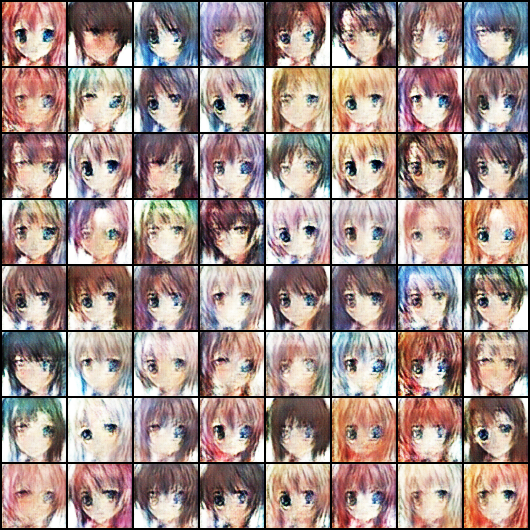

In [ ]:
from IPython.display import Image
Image('./generated/generated-images-0005.png')

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [ ]:
# os.listdir('./gans_training.avi')
from google.colab import files
files.download('gans_training.avi')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

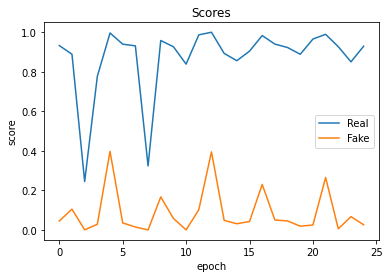

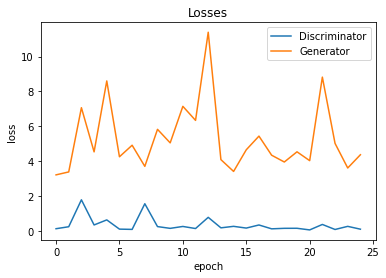

In [ ]:
# Plot the accuracy and loss curve
def plot_accuracies(real_scores,fake_scores):
  plt.figure()
  plt.plot(real_scores, '-')
  plt.plot(fake_scores, '-')
  plt.xlabel('epoch')
  plt.ylabel('score')
  plt.legend(['Real', 'Fake'])
  plt.title('Scores');


def plot_losses(losses_d,losses_g):
  plt.figure()
  plt.plot(losses_d, '-')
  plt.plot(losses_g, '-')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Discriminator', 'Generator'])
  plt.title('Losses');

plot_accuracies(real_scores,fake_scores)
plot_losses(losses_d,losses_g)

# Conclusion
* The GAN is able to generate images of anime. 
* By training more epochs, both the discriminator and generator can be trained to perform better.
* By changing Hyper parameters, we can achieve better performance of generator as the loss is still high.